In [ ]:
! pip install --upgrade pip

In [ ]:

!pip install kats


In [ ]:
!pip install pycausalimpact

In [ ]:
!pip install statsmodels

In [ ]:
# ! pip install -U numpy 

In [ ]:
# !pip install NumPy==1.20 

In [ ]:
# Start writing code here...

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_style('darkgrid')
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import month_plot
from kats.consts import TimeSeriesData
from kats.detectors.bocpd import BOCPDetector, BOCPDModelType, TrendChangeParameters
from kats.models.prophet import ProphetModel, ProphetParams
# from kats.tsfeatures.tsfeatures import TsFeatures
from causalimpact import CausalImpact
from kats.utils.decomposition import TimeSeriesDecomposition
from statsmodels.tsa.seasonal import seasonal_decompose

plt.rcParams["figure.figsize"] = (10,5)
sns.set_style('darkgrid')

In [ ]:
data = pd.read_csv('Retail Sales.csv', parse_dates=['DATE'])
data['DATE'] = data['DATE'].dt.date
data.head()

,DATE,Sales
0,1992-01-01,1509
1,1992-02-01,1541
2,1992-03-01,1597
3,1992-04-01,1675
4,1992-05-01,1822


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 352 entries, 0 to 351
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   DATE    352 non-null    object
 1   Sales   352 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.6+ KB


In [ ]:
data.describe()

,Sales
count,352.000000
mean,3122.267045
std,1129.410411
min,1501.000000
25%,2140.000000
50%,2986.500000
75%,3804.750000
max,7366.000000


In [ ]:
data['DATE'].nunique()

352

<AxesSubplot:>

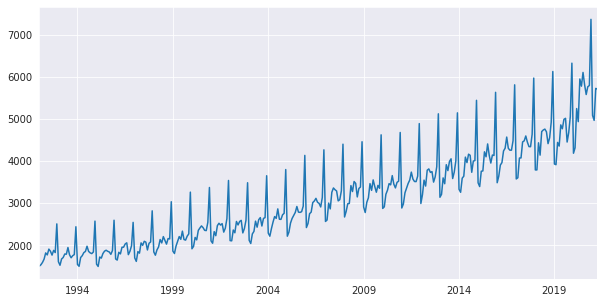

In [ ]:
time_series = pd.Series(data['Sales'].values, index=pd.date_range('1992-01-01', periods= 352, freq='M' ))
time_series.plot()

<AxesSubplot:>

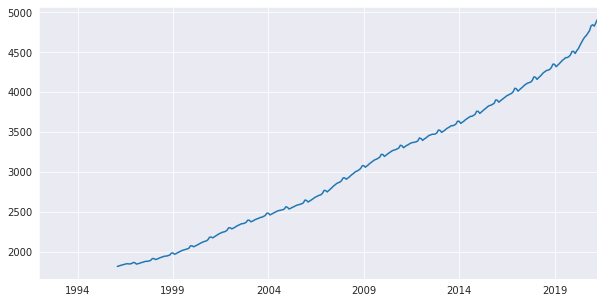

In [ ]:
rolling_mean = time_series.rolling(50).mean()
rolling_mean.plot()

<AxesSubplot:>

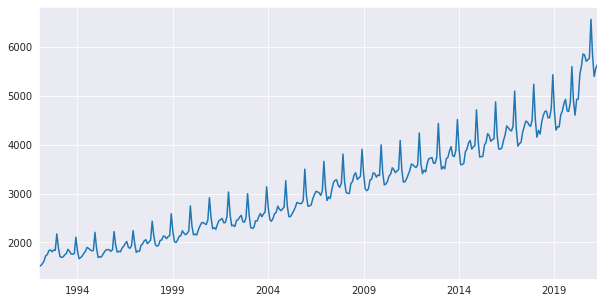

In [ ]:
exp_mean = time_series.ewm(1.0).mean()
exp_mean.plot()

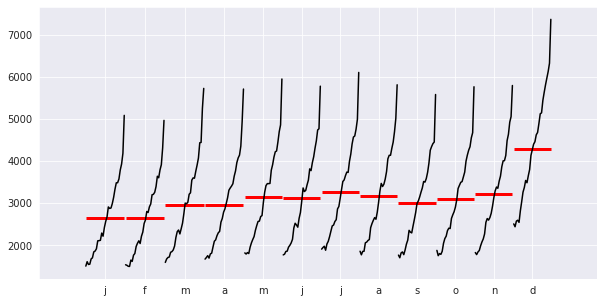

In [ ]:
fig = month_plot(time_series)

In [ ]:
retail_mul = seasonal_decompose(time_series, model='multiplicative')

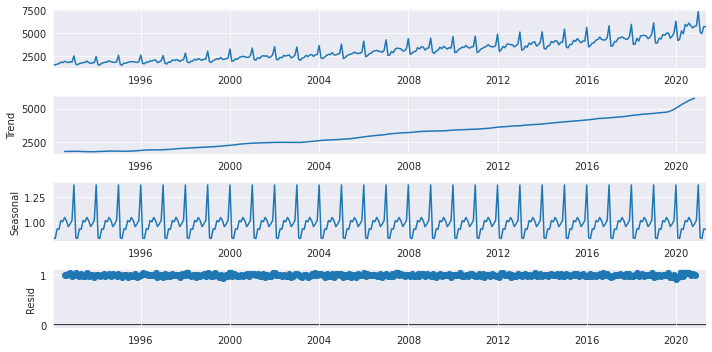

In [ ]:
# plt.figure(figsize=(14,9))
fig = retail_mul.plot()

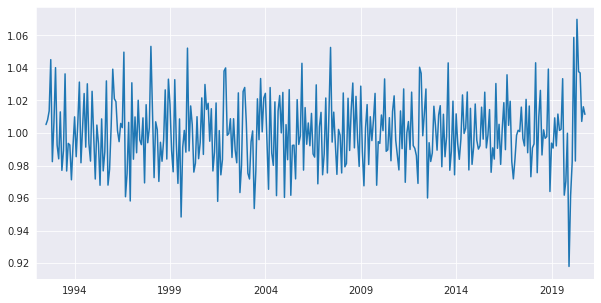

In [ ]:
fig = retail_mul.resid.plot()

In [ ]:
adfuller(time_series,autolag = 'AIC')

(2.263311168884347,
 0.9989306816415178,
 16,
 335,
 {'1%': -3.4500219858626227,
  '5%': -2.870206553997666,
  '10%': -2.571387268879483},
 4032.1374259455097)

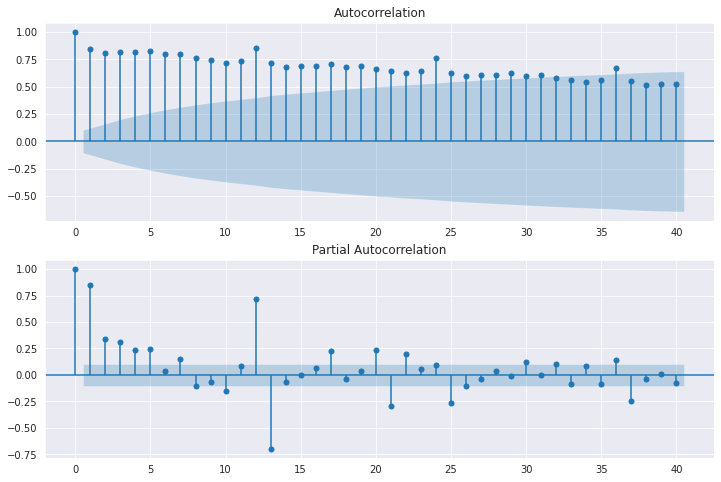

In [ ]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize = (12,8))
fig1 = plot_acf(time_series, lags=40, ax=ax1)
fig2= plot_pacf(time_series, lags=40, ax=ax2)

In [ ]:
data.columns = ["time", "value"]
ts = TimeSeriesData(data)

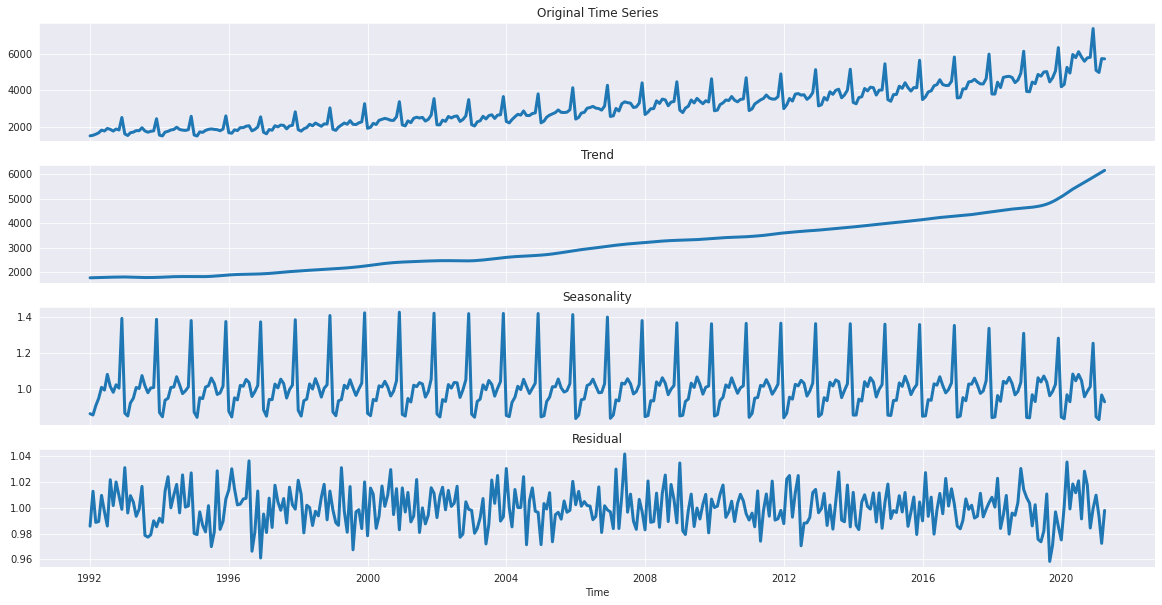

In [ ]:
decomposer = TimeSeriesDecomposition(ts, decomposition="multiplicative")
results = decomposer.decomposer()
fig = decomposer.plot()

TimeSeriesChangePoint(start_time: 2020-05-01T00:00:00.000000000, end_time: 2020-05-01T00:00:00.000000000, confidence: 0.7075252873104964)


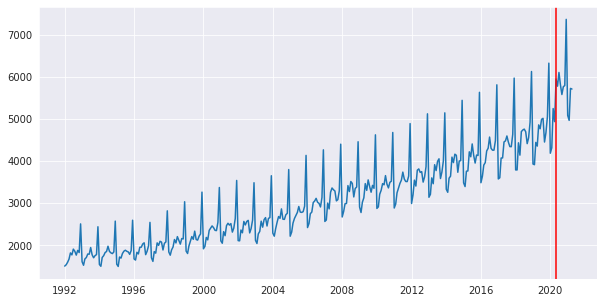

In [ ]:
bocpd_detector = BOCPDetector(ts)

changepoints = bocpd_detector.detector(
    model=BOCPDModelType.NORMAL_KNOWN_MODEL, changepoint_prior=0.01
)
for changepoint in changepoints:
    print(changepoint[0])
    
# Plot
bocpd_detector.plot(changepoints)

In [ ]:
time_series

1992-01-31    1509
1992-02-29    1541
1992-03-31    1597
1992-04-30    1675
1992-05-31    1822
              ... 
2020-12-31    7366
2021-01-31    5087
2021-02-28    4968
2021-03-31    5727
2021-04-30    5712
Freq: M, Length: 352, dtype: int64

In [ ]:
data_impact = data.iloc[0:-8,:]

In [ ]:
data_impact.shape


(344, 2)

In [ ]:
data_impact.tail()

,time,value
339,2020-04-01,4938
340,2020-05-01,5950
341,2020-06-01,5780
342,2020-07-01,6106
343,2020-08-01,5813


In [ ]:
data_series = pd.Series(data_impact['value'].values, index=pd.date_range('1992-01-01', periods= 344, freq='M' ))

In [ ]:
data_series.columns = ['value']
data_series

1992-01-31    1509
1992-02-29    1541
1992-03-31    1597
1992-04-30    1675
1992-05-31    1822
              ... 
2020-04-30    4938
2020-05-31    5950
2020-06-30    5780
2020-07-31    6106
2020-08-31    5813
Freq: M, Length: 344, dtype: int64

In [ ]:
# Define training data - period prior to the event
pre_period = ['1992-01-31', '2020-04-30'] 
# Define post-event period - i.e. time AFTER the event occurred.
post_period = ['2020-05-31', '2020-08-31'] 
# Instantiate CI model.
ci = CausalImpact(data_series, pre_period, post_period, nseasons=[{'period': 12}])

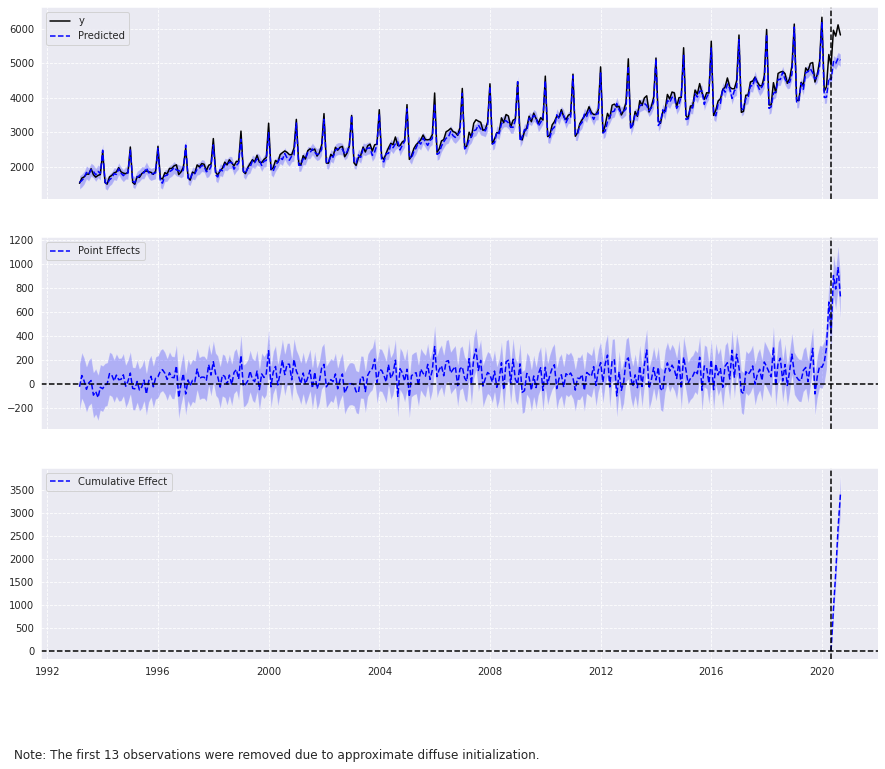

In [ ]:
ci.plot()

In [ ]:
print(ci.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    5912.25            23649.0
Prediction (s.d.)         5064.98 (51.32)    20259.94 (205.27)
95% CI                    [4965.59, 5166.75] [19862.37, 20667.02]

Absolute effect (s.d.)    847.27 (51.32)     3389.06 (205.27)
95% CI                    [745.5, 946.66]    [2981.98, 3786.63]

Relative effect (s.d.)    16.73% (1.01%)     16.73% (1.01%)
95% CI                    [14.72%, 18.69%]   [14.72%, 18.69%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [ ]:
# print(ci.summary_data())
print(ci.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 5912.25. By contrast, in the absence of an
intervention, we would have expected an average response of 5064.98.
The 95% interval of this counterfactual prediction is [4965.59, 5166.75].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 847.27 with a 95% interval of
[745.5, 946.66]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 23649.0.
By contrast, had the intervention not taken place, we would have expected
a sum of 20259.94. The 95% interval of this prediction is [19862.37, 20667.02].


The above results are given in terms of absolute numbers. In relative
terms, th

In [ ]:
ci.trained_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                Unobserved Components Results                                
=============================================================================================
Dep. Variable:                                     y   No. Observations:                  340
Model:                                   local level   Log Likelihood                 211.790
                   + stochastic freq_seasonal(12(6))   AIC                           -417.580
Date:                               Thu, 02 Sep 2021   BIC                           -406.210
Time:                                       09:21:38   HQIC                          -413.043
Sample:                                   01-31-1992                                         
                                        - 04-30-2020                                         
Covariance Type:                                 opg                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
sigma2.irregular               0.0029      0.000      7.562      0.000       0.002       0.004
sigma2.level                   0.0001   1.38e-05     10.456      0.000       0.000       0.000
sigma2.freq_seasonal_12(6)  2.963e-05   5.14e-06      5.767      0.000    1.96e-05    3.97e-05
===================================================================================
Ljung-Box (L1) (Q):                   4.12   Jarque-Bera (JB):               387.29
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               3.29   Skew:                             1.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

[negative_aic](https://www.statology.org/negative-aic/)

/root/venv/lib/python3.7/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.



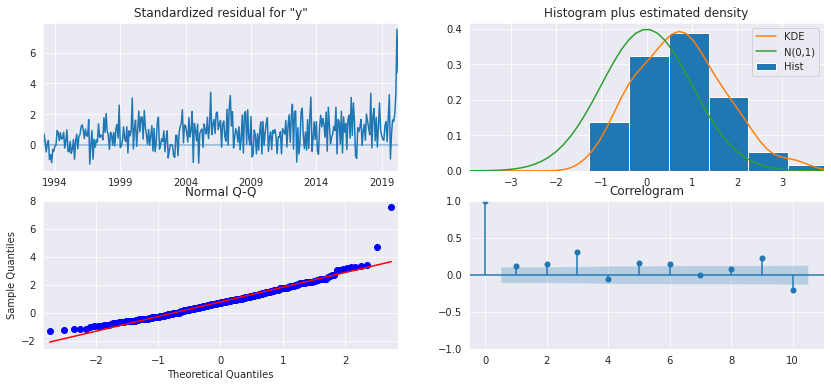

In [ ]:
_ = ci.trained_model.plot_diagnostics(figsize=(14,6))

In [ ]:
data_series = data_series.reset_index()
data_series.columns = ['time', 'value']
ts1 = TimeSeriesData(data_series)
ts1


,time,value
0,1992-01-31,1509
1,1992-02-29,1541
2,1992-03-31,1597
3,1992-04-30,1675
4,1992-05-31,1822
...,...,...
339,2020-04-30,4938
340,2020-05-31,5950
341,2020-06-30,5780
342,2020-07-31,6106


In [ ]:
params = ProphetParams(seasonality_mode="multiplicative")

# Create a model instance
m = ProphetModel(ts1, params)

# Fit mode
m.fit()

# Forecast
fcst = m.predict(steps=8, freq="M")
print(fcst)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
Initial log joint probability = -4.71999
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1176.3    0.00188434       166.243      0.1573      0.1573      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     162       1181.55   0.000101941        168.43   7.197e-07       0.001      250  LS failed, Hessian reset 
     199        1183.2     0.0039196       220.267           1           1      291   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     202       1183.34   0.000871969       368.834   6.463e-06       0.001      330  LS failed, Hessian reset 
     262       1184.22   6.67804e-05       115.102   5.223e-07       0.001      4

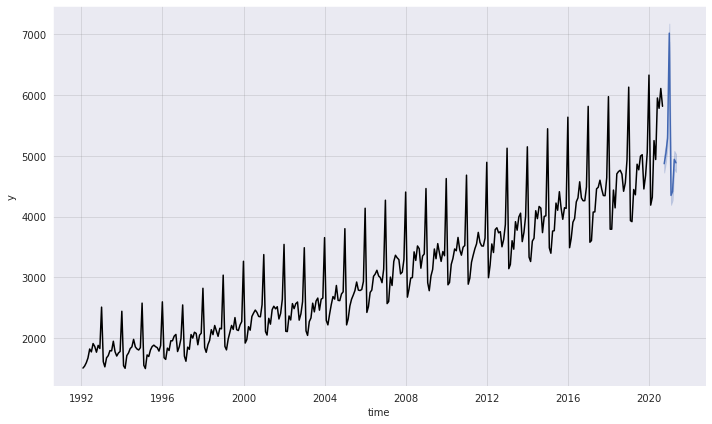

In [ ]:
m.plot()

In [ ]:
forecast_actual = pd.DataFrame(fcst)
true_data = data.iloc[-8:,1]
forecast_actual['true_value'] = list(true_data.values)
forecast_actual['diff'] = forecast_actual['true_value'] - forecast_actual['fcst']
forecast_actual['adjusted_sales_by_absolute_value'] = forecast_actual['fcst'] + 847.27
forecast_actual['adjusted_sales_by_relative_effect'] = forecast_actual['fcst'] * 1.1471
forecast_actual['adjusted_sales_lower_by_relative_effect'] = forecast_actual['fcst_lower'] * 1.1471
forecast_actual['adjusted_sales_absolute_by_relative_effect'] = forecast_actual['fcst_lower'] * 1.1673
forecast_actual['adjusted_sales_by_relative_effect_absolute'] = forecast_actual['fcst'] * 1.1673
forecast_actual['adjusted_sales_by_relative_effect_upper'] = forecast_actual['fcst'] * 1.1881
forecast_actual['if_meet_boundaries'] =  forecast_actual['true_value'].between(forecast_actual['fcst_lower'], forecast_actual['fcst_upper'])
forecast_actual['meet_relative_interval'] = forecast_actual['true_value'].between(forecast_actual['adjusted_sales_by_relative_effect'], forecast_actual['adjusted_sales_by_relative_effect_upper'])
forecast_actual

,time,fcst,fcst_lower,fcst_upper,true_value,diff,adjusted_sales_by_absolute_value,adjusted_sales_by_relative_effect,adjusted_sales_lower_by_relative_effect,adjusted_sales_absolute_by_relative_effect,adjusted_sales_by_relative_effect_absolute,adjusted_sales_by_relative_effect_upper,if_meet_boundaries,meet_relative_interval
0,2020-09-30,4869.014622,4724.367228,5018.426048,5582,712.985378,5716.284622,5585.246673,5419.321648,5514.753866,5683.600768,5784.876272,False,False
1,2020-10-31,5038.202699,4893.418763,5178.688868,5766,727.797301,5885.472699,5779.322316,5613.240662,5712.087721,5881.094010,5985.888627,False,False
2,2020-11-30,5289.120863,5150.279079,5432.865575,5796,506.879137,6136.390863,6067.150542,5907.885131,6011.920768,6173.990783,6284.004497,False,False
3,2020-12-31,7016.007295,6873.452661,7172.125710,7366,349.992705,7863.277295,8048.061968,7884.537547,8023.381291,8189.785315,8335.718267,False,False
4,2021-01-31,4347.843354,4193.259005,4479.092358,5087,739.156646,5195.113354,4987.411112,4810.087404,4894.791236,5075.237547,5165.672689,False,True
5,2021-02-28,4412.951305,4267.022874,4570.303270,4968,555.048695,5260.221305,5062.096442,4894.701938,4980.895801,5151.238059,5243.027446,False,False
6,2021-03-31,4940.784842,4783.082722,5079.966969,5727,786.215158,5788.054842,5667.574292,5486.674190,5583.292461,5767.378146,5870.146470,False,True
7,2021-04-30,4883.808117,4732.082446,5029.045687,5712,828.191883,5731.078117,5602.216291,5428.171774,5523.759840,5700.869215,5802.452424,False,True


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
y_true = forecast_actual['true_value'].values
y_pred_actual = forecast_actual['fcst'].values
y_pred_upper = forecast_actual['fcst_upper'].values
y_pred_relative_effect = forecast_actual['adjusted_sales_by_relative_effect'].values
y_pred_relative_effect_absolute = forecast_actual['adjusted_sales_by_relative_effect_absolute'].values
y_pred_absolute_value = forecast_actual['adjusted_sales_by_absolute_value'].values
y_pred_lower_relative_effect = forecast_actual['adjusted_sales_lower_by_relative_effect'].values
y_pred_absolute_relative_effect = forecast_actual['adjusted_sales_absolute_by_relative_effect'].values
mean_absolute_error(y_true, y_pred_actual), mean_absolute_error(y_true, y_pred_upper), mean_absolute_error(y_true, y_pred_relative_effect), mean_absolute_error(y_true, y_pred_absolute_value), mean_absolute_error(y_true, y_pred_relative_effect_absolute), mean_absolute_error(y_true, y_pred_lower_relative_effect), mean_absolute_error(y_true, y_pred_absolute_relative_effect)

(650.7833629380818,
 505.4356893626277,
 166.58453073345777,
 196.48663706191815,
 208.12253979921832,
 227.5281326131477,
 191.43909196394304)

In [ ]:
np.sqrt(mean_absolute_error(y_true, y_pred_actual)), np.sqrt(mean_absolute_error(y_true, y_pred_upper)), np.sqrt(mean_absolute_error(y_true, y_pred_relative_effect)), np.sqrt(mean_absolute_error(y_true, y_pred_absolute_value)), np.sqrt(mean_absolute_error(y_true, y_pred_relative_effect_absolute)),np.sqrt(mean_absolute_error(y_true, y_pred_lower_relative_effect)), np.sqrt(mean_absolute_error(y_true, y_pred_absolute_relative_effect))

(25.510455953159322,
 22.481896925362587,
 12.906762984321738,
 14.017369120556046,
 14.4264527795026,
 15.084035687214072,
 13.836151631286173)

In [ ]:
mean_absolute_percentage_error(y_true, y_pred_actual), mean_absolute_percentage_error(y_true, y_pred_upper), mean_absolute_percentage_error(y_true, y_pred_relative_effect), mean_absolute_percentage_error(y_true, y_pred_absolute_value), mean_absolute_percentage_error(y_true, y_pred_relative_effect_absolute), mean_absolute_percentage_error(y_true, y_pred_lower_relative_effect), mean_absolute_percentage_error(y_true, y_pred_absolute_relative_effect)

(0.11602763644537656,
 0.09048640192150932,
 0.026298044214337284,
 0.033136223894259395,
 0.032926170991483567,
 0.038272410423672146,
 0.03079050431878704)

In [ ]:
# ! pip install -U NumPy==1.20 

In [ ]:
# ! pip install --upgrade pip

In [ ]:
# ! pip install numba

In [ ]:


# model = TsFeatures()

# output_features = model.transform(ts1)

In [ ]:
# output_features

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=78737810-407f-49e2-ad32-0363e2fb2f04' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>